# 1. SARIMA

Step 1: we're just going to do straight SARIMA on the minimal dataframe, which has two predictors (obesity and diabetes prevalence per state per year) and one target (mortality per 100K from heart attack per state per year).

In [1]:
import pickle
import pandas as pd
import numpy as np
import itertools
import statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_squared_error

import warnings
import math

from progress_bar import log_progress

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = [8.0, 6.0]
plt.rcParams['figure.dpi'] = 250
plt.rcParams['savefig.dpi'] = 250

In [3]:
# my own helper functions
import sarimax_helper_functions
from sarimax_helper_functions import evaluate_arimax_model_using_forecasting, evaluate_arimax_model_using_prediction, get_test_forecast_from_arimax_with_params, get_test_prediction_from_arimax_with_params, make_arimax_model_with_params, make_all_possible_param_dictionaries

In [5]:
with open("../data/pickles/cardiac_mortality_obesity_dm_df_by_state.pkl", "rb") as picklefile:
    state_mortality_dict = pickle.load(picklefile)

In [6]:
california_df = state_mortality_dict['California']

In [7]:
california_df.dropna(inplace=True)

In [8]:
# Define the p, d and q parameters to take any value between 0 and 1
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [14]:
param_choices = {}
param_choices['order'] = pdq
param_choices['seasonal'] = seasonal_pdq
param_choices['trend'] = ['c', 'ct', 't', 'n']
param_choices['enforce_stationarity'] = [True, False]
param_choices['enforce_invertibility'] = [True, False]

In [15]:
list_of_SARIMA_dicts = make_all_possible_param_dictionaries(param_choices=param_choices)

In [16]:
comparison_list_forecasting = []

for index, SARIMA_parameter_dictionary in log_progress(enumerate(list_of_SARIMA_dicts), every=1, size=len(list_of_SARIMA_dicts)):
    aic, test_rmse = evaluate_arimax_model_using_forecasting(SARIMA_parameter_dictionary, california_df['mortality_per_100k'])
    comparison_list_forecasting.append((index, aic, test_rmse))

In [11]:
parameter_gridsearch_df = pd.DataFrame(comparison_list_forecasting, columns=['parameter_dict_number', 'aic', 'forecast_test_mse'])
parameter_gridsearch_df.set_index('parameter_dict_number', inplace=True)

In [12]:
parameter_gridsearch_df.sort_values(by='aic').head(10)

,aic,forecast_test_mse
parameter_dict_number,,
1515,-74.799138,0.240341
1596,-73.011460,0.239060
870,-72.190489,0.218443
222,-71.644698,0.229874
1518,-70.433374,0.194955
1599,-70.318094,0.233583
141,-69.898651,0.222350
143,-69.680791,0.369583
951,-69.600106,0.221566


In [17]:
best_by_aic = list(parameter_gridsearch_df.sort_values(by='aic').head(10).index)

In [18]:
best_by_aic

[1515, 1596, 870, 222, 1518, 1599, 141, 143, 951, 789]

In [20]:
parameter_gridsearch_df.sort_values(by='forecast_test_mse').head(10)

,aic,forecast_test_mse
parameter_dict_number,,
2085,-40.035857,0.139960
1650,-44.855902,0.143879
1007,-34.393129,0.144501
921,-45.360703,0.145396
1488,-48.837934,0.145614
1569,-47.370677,0.145829
1736,-34.699825,0.146177
840,-48.493744,0.146954
192,-46.833212,0.148542


In [21]:
best_by_mse = list(parameter_gridsearch_df.sort_values(by='forecast_test_mse').head(10).index)

In [22]:
best_by_mse

[2085, 1650, 1007, 921, 1488, 1569, 1736, 840, 192, 1356]

In [30]:
for d in best_by_aic:
    print(list_of_SARIMA_dicts[d])

{'order': (2, 0, 0), 'seasonal': (2, 0, 1, 12), 'trend': 'c', 'enforce_stationarity': False, 'enforce_invertibility': False}
{'order': (2, 0, 1), 'seasonal': (2, 0, 1, 12), 'trend': 'c', 'enforce_stationarity': False, 'enforce_invertibility': False}
{'order': (1, 0, 1), 'seasonal': (2, 0, 2, 12), 'trend': 'c', 'enforce_stationarity': False, 'enforce_invertibility': False}
{'order': (0, 0, 2), 'seasonal': (2, 0, 2, 12), 'trend': 'c', 'enforce_stationarity': False, 'enforce_invertibility': False}
{'order': (2, 0, 0), 'seasonal': (2, 0, 2, 12), 'trend': 'c', 'enforce_stationarity': False, 'enforce_invertibility': False}
{'order': (2, 0, 1), 'seasonal': (2, 0, 2, 12), 'trend': 'c', 'enforce_stationarity': False, 'enforce_invertibility': False}
{'order': (0, 0, 1), 'seasonal': (2, 0, 2, 12), 'trend': 'c', 'enforce_stationarity': False, 'enforce_invertibility': False}
{'order': (0, 0, 1), 'seasonal': (2, 0, 2, 12), 'trend': 't', 'enforce_stationarity': False, 'enforce_invertibility': False}


In [31]:
for d in best_by_mse:
    print(list_of_SARIMA_dicts[d])

{'order': (2, 2, 1), 'seasonal': (2, 0, 2, 12), 'trend': 'c', 'enforce_stationarity': False, 'enforce_invertibility': False}
{'order': (2, 0, 2), 'seasonal': (1, 0, 1, 12), 'trend': 'c', 'enforce_stationarity': False, 'enforce_invertibility': False}
{'order': (1, 1, 0), 'seasonal': (1, 0, 2, 12), 'trend': 't', 'enforce_stationarity': False, 'enforce_invertibility': False}
{'order': (1, 0, 2), 'seasonal': (1, 0, 1, 12), 'trend': 'c', 'enforce_stationarity': False, 'enforce_invertibility': False}
{'order': (2, 0, 0), 'seasonal': (1, 0, 1, 12), 'trend': 'c', 'enforce_stationarity': False, 'enforce_invertibility': False}
{'order': (2, 0, 1), 'seasonal': (1, 0, 1, 12), 'trend': 'c', 'enforce_stationarity': False, 'enforce_invertibility': False}
{'order': (2, 1, 0), 'seasonal': (1, 0, 2, 12), 'trend': 't', 'enforce_stationarity': False, 'enforce_invertibility': False}
{'order': (1, 0, 1), 'seasonal': (1, 0, 1, 12), 'trend': 'c', 'enforce_stationarity': False, 'enforce_invertibility': False}


In [47]:
list_of_SARIMA_dicts[1515]

{'order': (2, 0, 0),
 'seasonal': (2, 0, 1, 12),
 'trend': 'c',
 'enforce_stationarity': False,
 'enforce_invertibility': False}

In [120]:
list_of_SARIMA_dicts[1007]

{'order': (1, 1, 0),
 'seasonal': (1, 0, 2, 12),
 'trend': 't',
 'enforce_stationarity': False,
 'enforce_invertibility': False}

In [178]:
test_dict = {
    'order': (1, 1, 0),
    'seasonal': (0, 1, 1, 12),
    'trend': 'ct',
    'enforce_stationarity': False,
    'enforce_invertibility': False
}

In [179]:
test_forecast = get_test_forecast_from_arimax_with_params(test_dict, california_df['mortality_per_100k'], train_fraction=0.55)

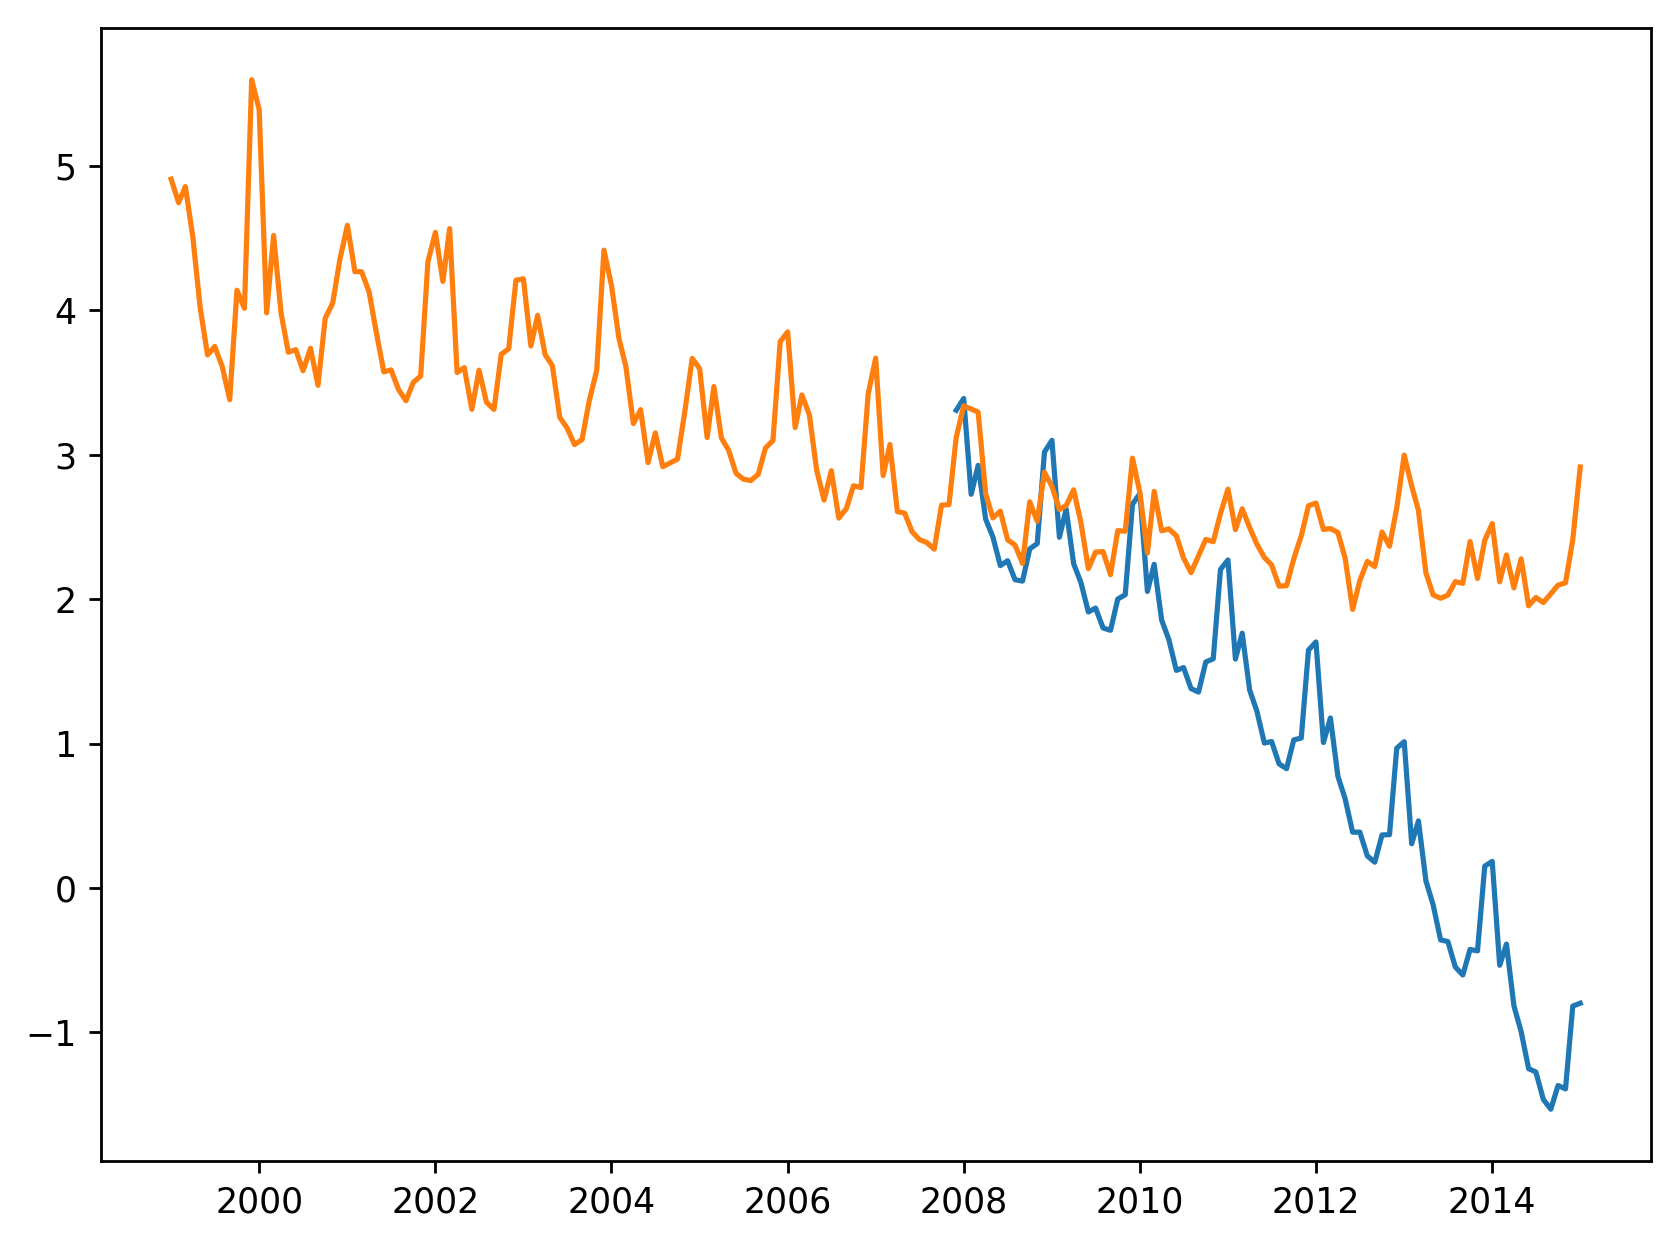

In [180]:
plt.plot(test_forecast)
plt.plot(california_df['mortality_per_100k'])

In [121]:
california_prediction = get_test_prediction_from_arimax_with_params(list_of_SARIMA_dicts[1515], california_df['mortality_per_100k'], train_fraction=0.4)

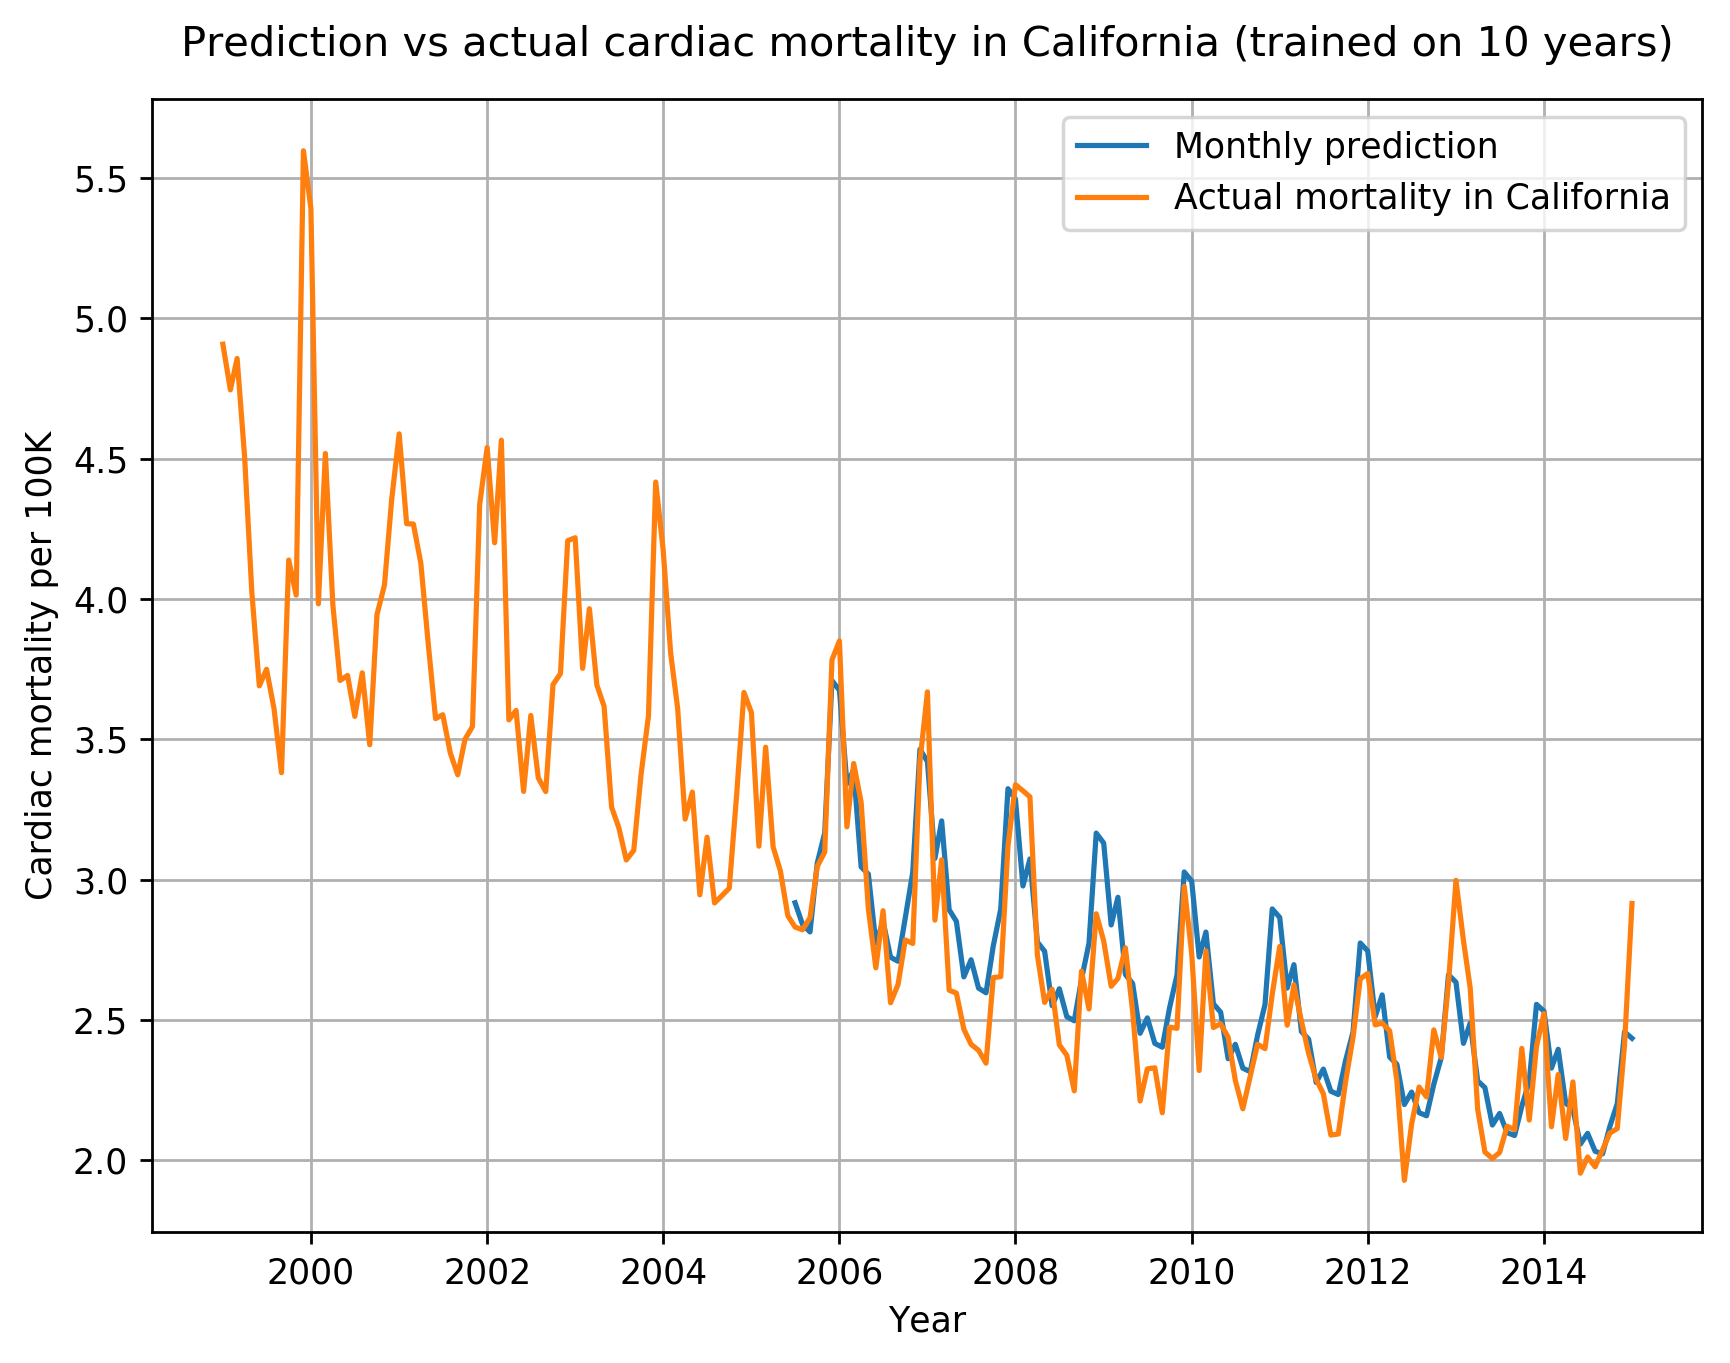

In [130]:
plt.plot(california_prediction, label = "Monthly prediction")
plt.plot(california_df['mortality_per_100k'], label = "Actual mortality in California")

plt.title("Prediction vs actual cardiac mortality in California (trained on 10 years)", y = 1.02)

plt.xlabel("Year")
plt.ylabel("Cardiac mortality per 100K")

plt.grid()
plt.legend()



plt.show()

The quality of the forecast is heavily dependent how much of the data it has trained on, or what data it sees when it trained. When we did gridsearch in order to get that 2085 has the lowest MSE, this was with a training fraction of 0.66. If you set the training fraction to 0.4, the forecast looks horrible.

In [111]:
california_forecast = get_test_forecast_from_arimax_with_params(list_of_SARIMA_dicts[1007], california_df['mortality_per_100k'], train_fraction=0.6)

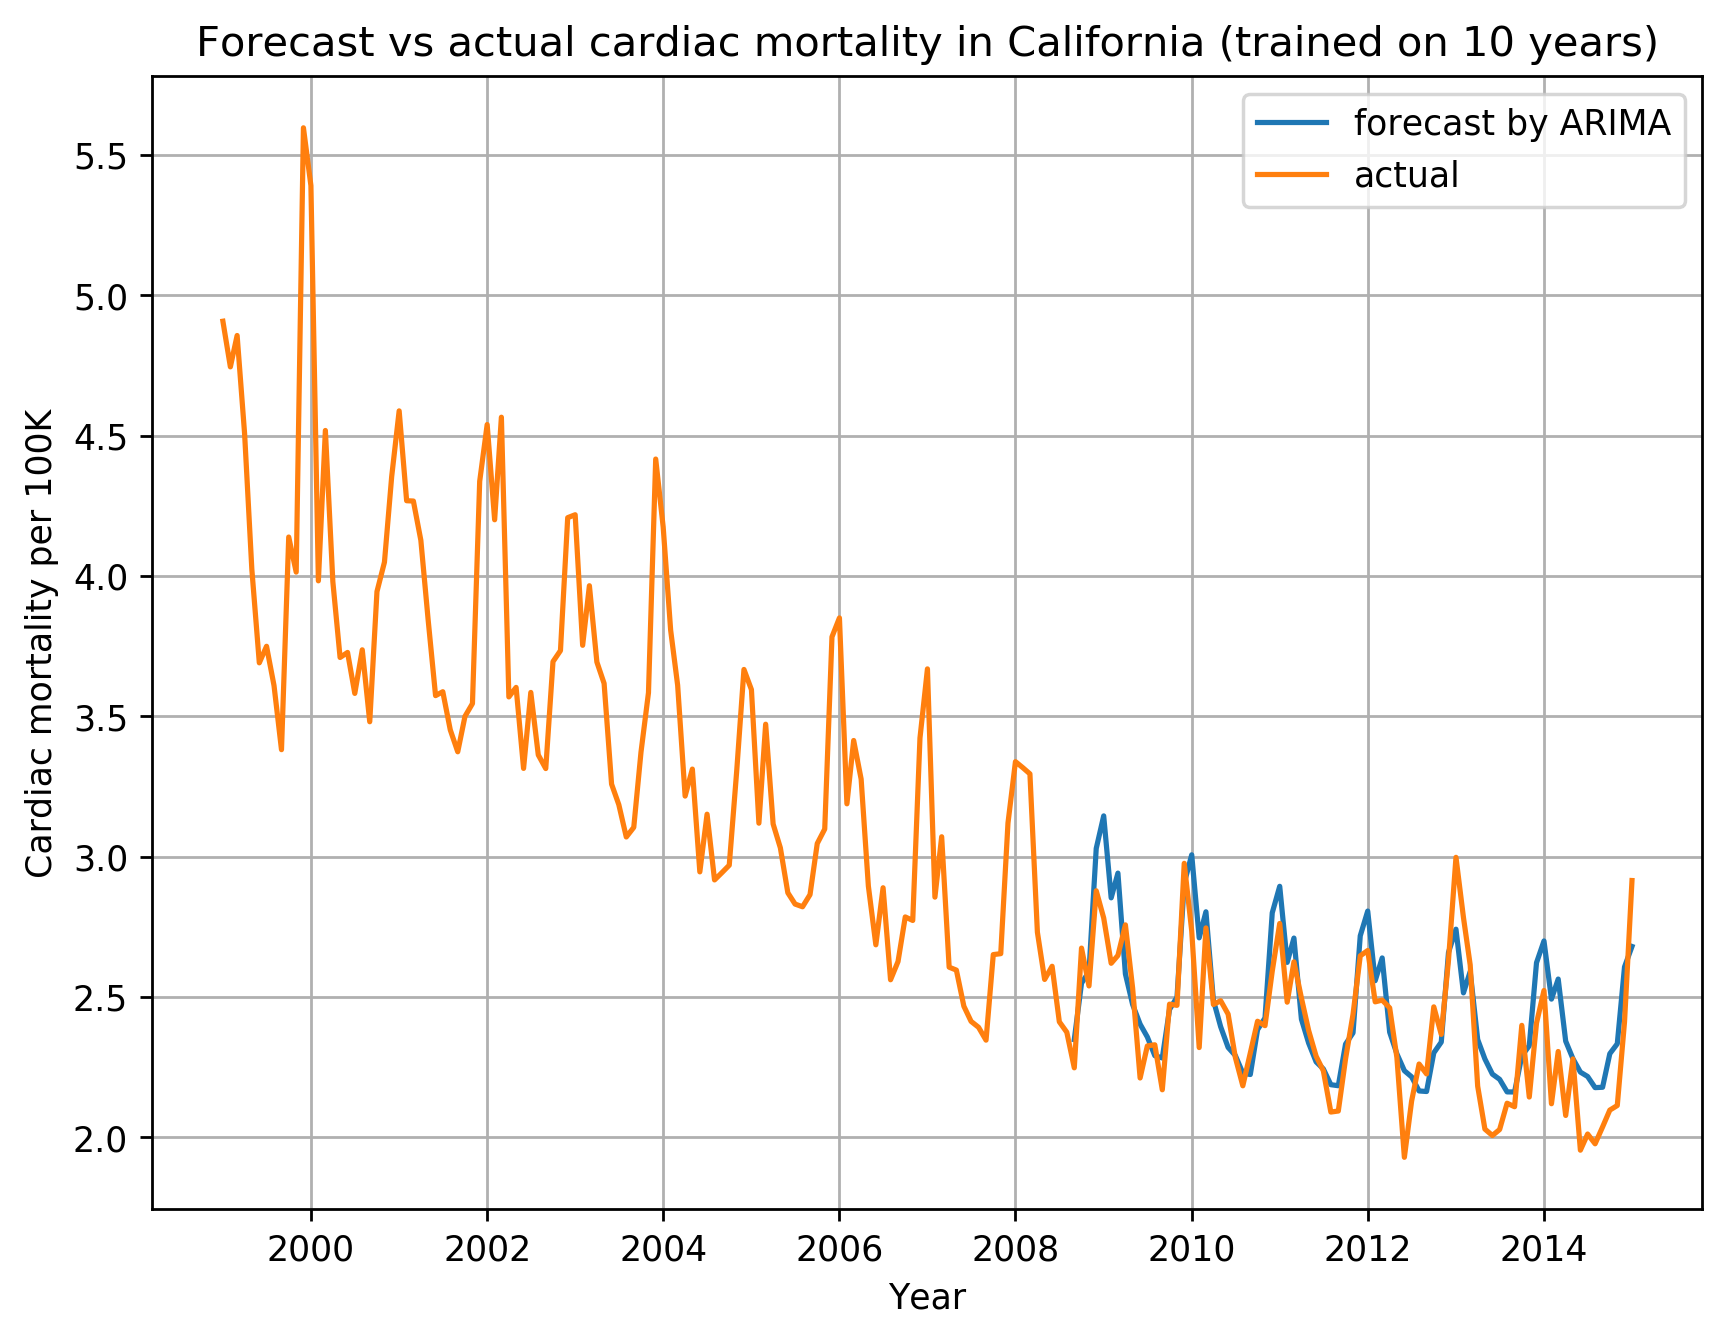

In [112]:
plt.plot(california_forecast, label="forecast by ARIMA")
plt.plot(california_df['mortality_per_100k'], label="actual")
plt.grid()
plt.legend()
plt.xlabel("Year")
plt.ylabel("Cardiac mortality per 100K")
plt.title("Forecast vs actual cardiac mortality in California (trained on 10 years)")

#plt.savefig("../figures/california_forecast_ARIMA_10y.png")
plt.savefig("../figures/california_forecast_ARIMA_10y_with_trend.png")
plt.show()

When we set the train_fraction to the same value that it was at for the gridsearch, we can see why the parameters for `2085` look great! But then let's change the training fraction to 0.4 and see what happens:

In [108]:
# list_of_SARIMA_dicts[2085]
list_of_SARIMA_dicts[1007]

{'order': (1, 1, 0),
 'seasonal': (1, 0, 2, 12),
 'trend': 't',
 'enforce_stationarity': False,
 'enforce_invertibility': False}

In [113]:
california_forecast = get_test_forecast_from_arimax_with_params(list_of_SARIMA_dicts[1007], california_df['mortality_per_100k'], train_fraction=0.4)

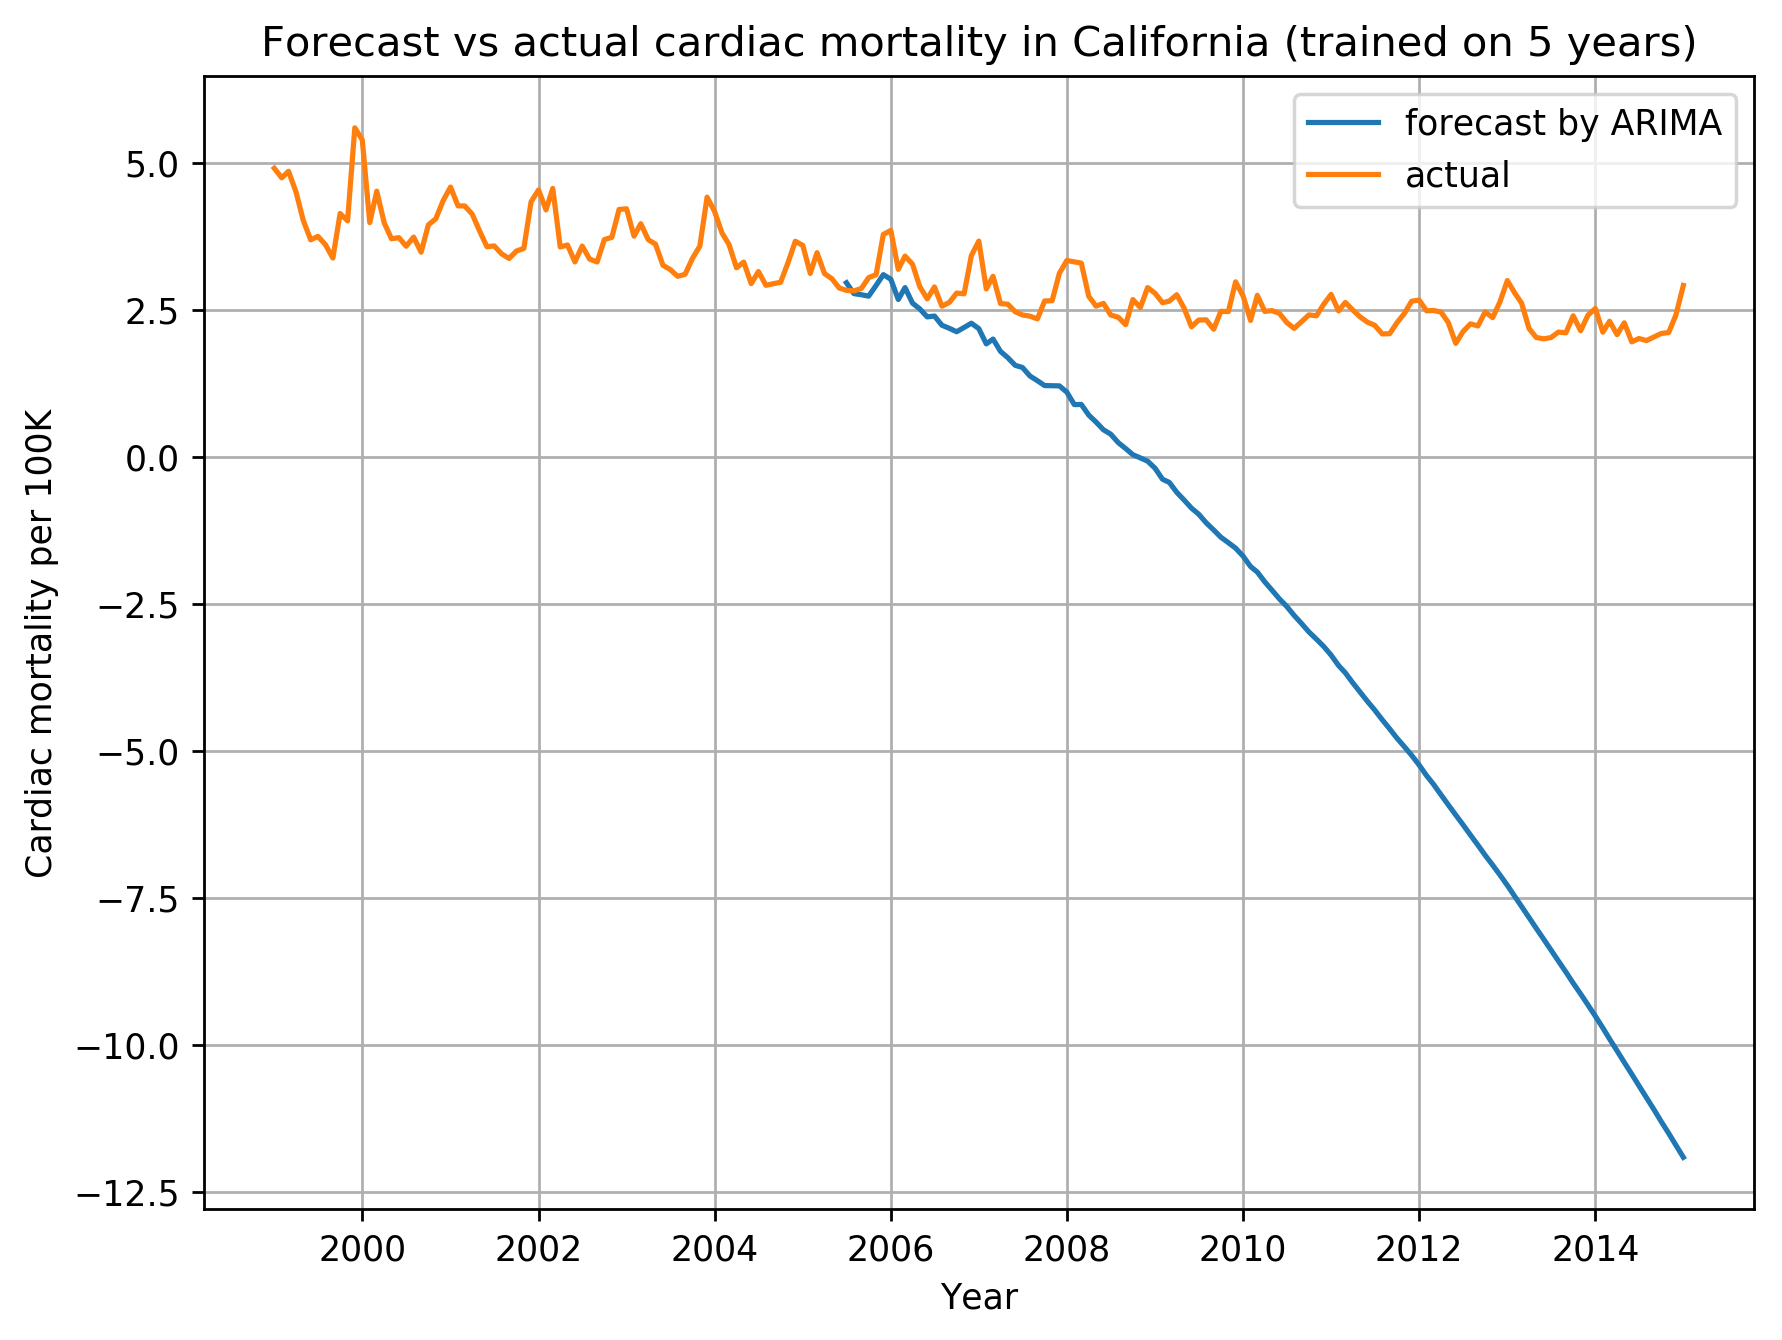

In [114]:
plt.plot(california_forecast, label="forecast by ARIMA")
plt.plot(california_df['mortality_per_100k'], label="actual")
plt.grid()
plt.legend()
plt.xlabel("Year")
plt.ylabel("Cardiac mortality per 100K")
plt.title("Forecast vs actual cardiac mortality in California (trained on 5 years)")

#plt.savefig("../figures/california_forecast_ARIMA_5y.png")
plt.savefig("../figures/california_forecast_ARIMA_5y_with_trend.png")
plt.show()

Let's try the parameters from `list_of_SARIMA_dicts[1650]` on another state's cardiac mortality data and see how well it forecasts.

In [201]:
state = 'Alabama'

In [202]:
state_df = state_mortality_dict[state]

In [208]:
state_forecast = get_test_forecast_from_arimax_with_params(list_of_SARIMA_dicts[1007], state_df['mortality_per_100k'], train_fraction=0.66)

In [205]:
list_of_SARIMA_dicts[1007]

{'order': (1, 1, 0),
 'seasonal': (1, 0, 2, 12),
 'trend': 't',
 'enforce_stationarity': False,
 'enforce_invertibility': False}

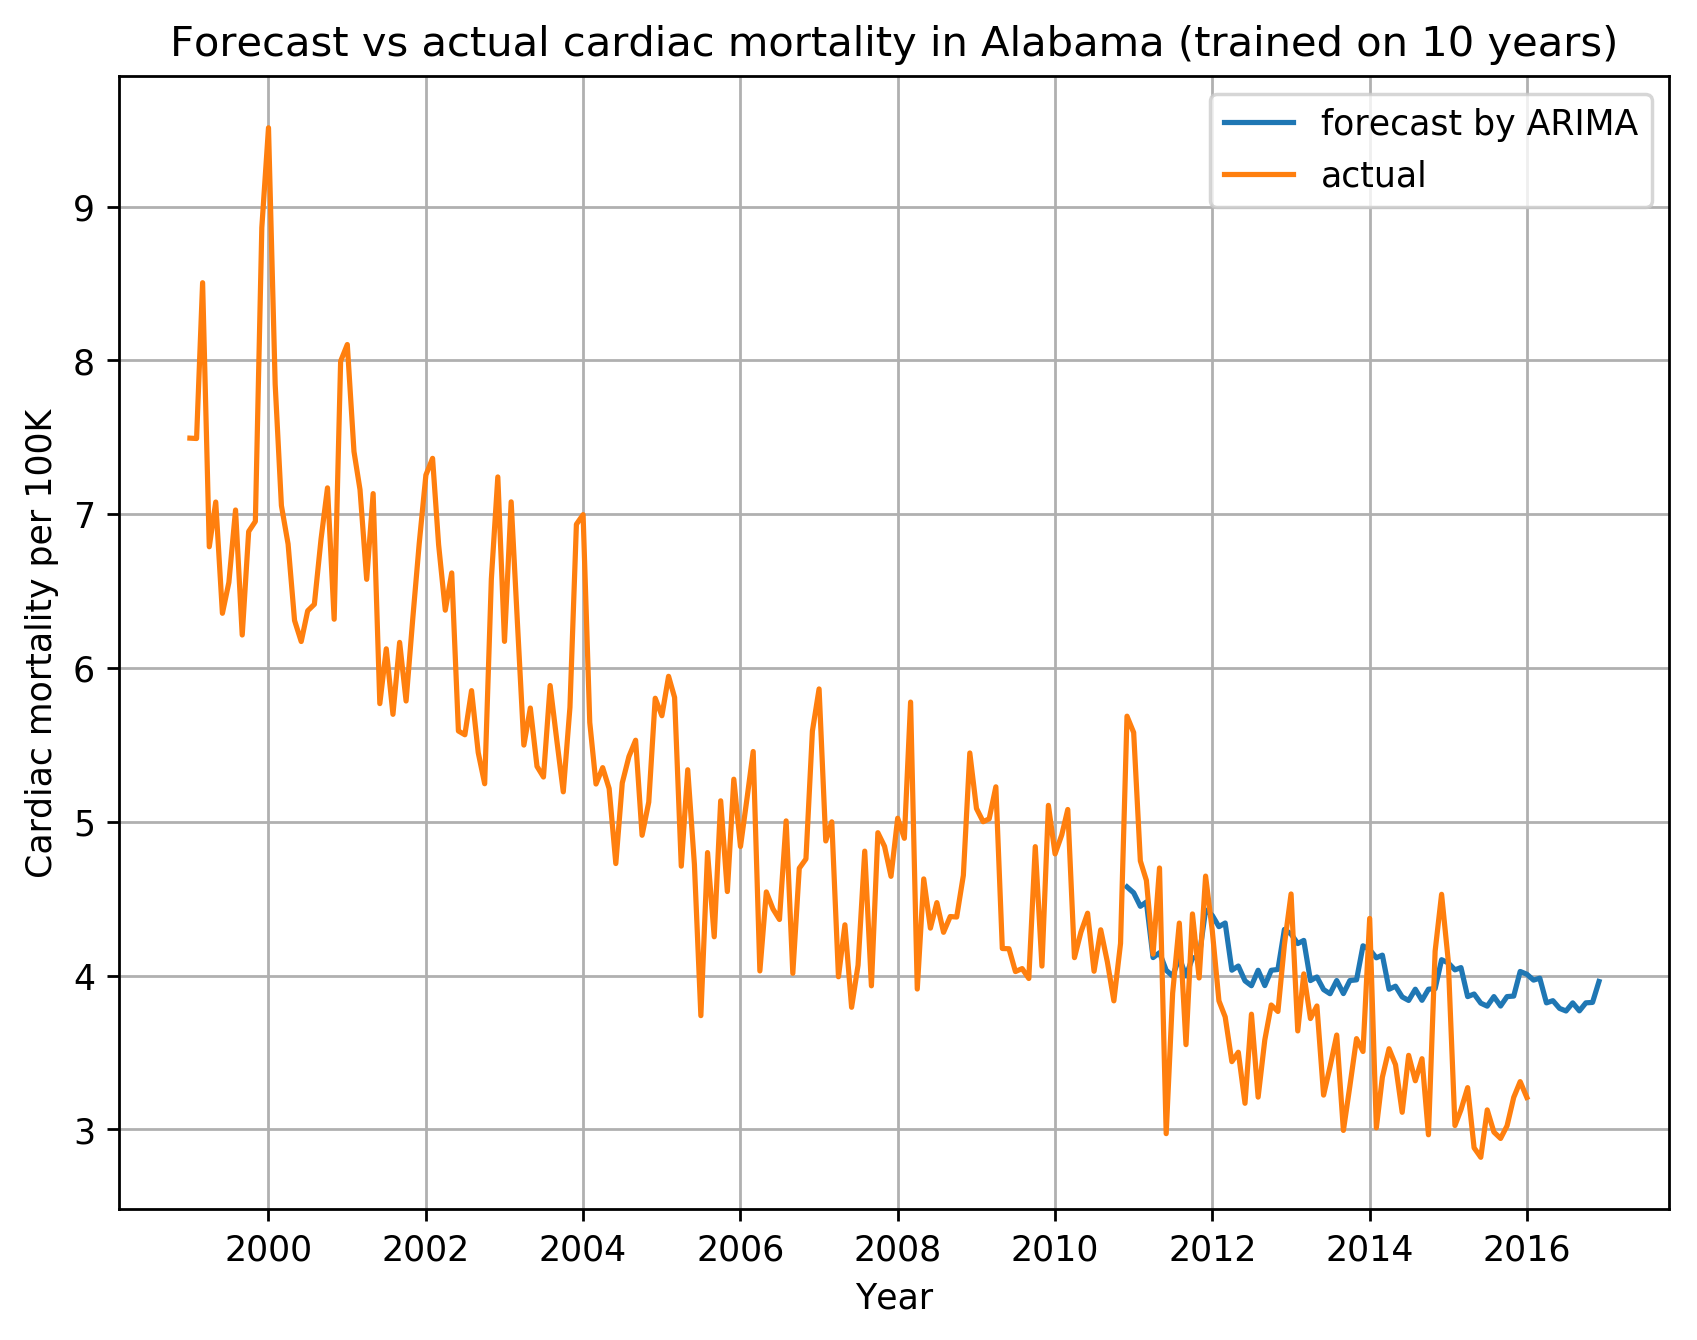

In [207]:
plt.plot(state_forecast, label="forecast by ARIMA")
plt.plot(state_df['mortality_per_100k'], label="actual")
plt.grid()
plt.legend()
plt.xlabel("Year")
plt.ylabel("Cardiac mortality per 100K")
plt.title(f"Forecast vs actual cardiac mortality in {state} (trained on 10 years)")

#plt.savefig(f"../figures/{state}_forecast_ARIMA_10y.png")
plt.savefig(f"../figures/{state}_forecast_ARIMA_10y_with_trend.png")
plt.show()

# 2. SARIMAX

Step 2: Now, we're going to try incorporating the exogenous variables of obesity and diabetes prevalance into our prediction. We're going to have to rewrite the helper functions in order to allow for the possibility of inputting exogenous variables. Now that we've rewritten it, let's go back to section 1 and make sure that the rewritten functions still work.

In [27]:
california_df.head()

,Deaths,obesity_prevalence,diabetes_prevalence,Population,mortality_per_100k
Month,,,,,
1999-01-01,1644.0,41.500000,6.50,33499204.0,4.907579
1999-02-01,1591.0,41.308333,6.55,33530241.0,4.744970
1999-03-01,1630.0,41.116667,6.60,33561278.0,4.856788
1999-04-01,1514.0,40.925000,6.65,33592315.0,4.506983
1999-05-01,1353.0,40.733333,6.70,33623352.0,4.023989


In [29]:
model = SARIMAX(california_df['mortality_per_100k'], exog=None)

In [32]:
time_series_length = len(california_df['mortality_per_100k'])

In [72]:
train_length = math.ceil(0.66*time_series_length)

In [76]:
target = california_df['mortality_per_100k']
exog_var=california_df[['obesity_prevalence', 'diabetes_prevalence']]

target_train = target[0:train_length]
target_test = target[train_length:]

exog_train = exog_var[0:train_length]
exog_test = exog_var[train_length:]

In [77]:
model = SARIMAX(target_train, exog=exog_train)

In [78]:
result = model.fit()

In [79]:
test_start_date = min(target_test.index)
test_end_date = max(target_test.index)

Okay, so let's try doing a gridsearch with exogenous variables.

In [13]:
comparison_list_forecasting_exog = []

for index, SARIMA_parameter_dictionary in log_progress(enumerate(list_of_SARIMA_dicts), every=1, size=len(list_of_SARIMA_dicts)):
    aic, test_rmse = evaluate_arimax_model_using_forecasting(SARIMA_parameter_dictionary, california_df['mortality_per_100k'], 0.66, california_df[['obesity_prevalence', 'diabetes_prevalence']])
    comparison_list_forecasting_exog.append((index, aic, test_rmse))

In [15]:
parameter_gridsearch_exog_df = pd.DataFrame(comparison_list_forecasting_exog, columns=['dict_num', 'AIC', 'test_RMSE'])
parameter_gridsearch_exog_df.set_index('dict_num', inplace=True)

In [18]:
parameter_gridsearch_exog_df.sort_values(by='test_RMSE').head(10)

,AIC,test_RMSE
dict_num,,
2166,-26.368891,0.141320
1734,-38.509366,0.142710
1569,-39.920566,0.144263
840,-45.240214,0.144399
1356,-31.715080,0.145584
1005,-36.404482,0.147044
1650,-36.795467,0.147144
192,-44.618564,0.147205
1488,-45.748953,0.149371


In [19]:
parameter_gridsearch_exog_df.sort_values(by='AIC').head(10)

,AIC,test_RMSE
dict_num,,
1515,-72.112625,0.270022
141,-70.442653,0.254391
1518,-70.165577,0.215213
222,-69.649411,0.248630
789,-69.592347,0.219984
870,-69.478468,0.214301
143,-68.730542,0.435107
872,-68.314182,0.369722
951,-66.285691,0.226835


In [20]:
with open("../data/pickles/interpol_truncated_MI_mortality_per_state_dict.pkl", "rb") as picklefile:
    clean_dict_of_state_dfs = pickle.load(picklefile)

In [21]:
alabama = clean_dict_of_state_dfs['Alabama']

In [23]:
alabama.tail()

,Deaths,obesity_prevalence,diabetes_prevalence,Population,mortality_per_100k
Month,,,,,
2014-09-01,168.0,62.900,11.933333,4.855778e+06,3.459795
2014-10-01,144.0,63.375,11.950000,4.856578e+06,2.965050
2014-11-01,202.0,63.850,11.966667,4.857379e+06,4.158622
2014-12-01,220.0,64.325,11.983333,4.858179e+06,4.528446
2015-01-01,199.0,64.800,12.000000,4.858979e+06,4.095511


## More exhaustive gridsearch

Okay, so after doing more reading, it looks like it would actually make more sense for p, d, q and P, D, Q to only take on values from 0 to 1. And then, what I'm more interested in is what the RMSE is with different training fractions, and then I'm also interested in what the best parameters are for different states.

In [181]:
# Define the p, d and q parameters to be either 0 or 1
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [184]:
param_choices = {}
param_choices['order'] = pdq
param_choices['seasonal'] = seasonal_pdq
param_choices['trend'] = ['c', 'ct', 't']
param_choices['enforce_stationarity'] = [True, False]
param_choices['enforce_invertibility'] = [True, False]

In [187]:
list_of_pdq_dicts = make_all_possible_param_dictionaries(param_choices=param_choices)

In [200]:
 pdq_list_index_to_test_rmse = {}

for index, SARIMA_parameter_dictionary in log_progress(enumerate(list_of_pdq_dicts), every=1, size=len(list_of_pdq_dicts)):
    test_rmse_list = []
    for i in range(5, 10):
        aic, test_rmse = evaluate_arimax_model_using_forecasting(SARIMA_parameter_dictionary, california_df['mortality_per_100k'], train_fraction=0.1*i)
        test_rmse_list.append(test_rmse)
    pdq_list_index_to_test_rmse[index] = test_rmse_list

LinAlgError: Singular matrix

If I were going to do this for multiple states, I would end up iterating through each state and brute force evaluating all the different combinations. I also think that it is possible that d might have to be more than 1 in order to make the process stationary, but it already takes a long time to do this brute force search.

Suggested parameters by Duke:

ARIMA(0,1,q)x(0,1,1) model (q=1 or 2)
ARIMA(p,0,0)x(0,1,1)+c model (p=1, 2 or 3)

In [197]:
# first set of models:
p = [0]
d = [1]
q = [1, 2]

P = [0]
D = [1]
Q = [1]

In [ ]:
# second set of models:
p = list(range(1,4))
d = [0]
q = [0]

P = [0]
D = [1]
Q = [1]

In [198]:
list(itertools.product(p, d, q))

[(0, 1, 1), (0, 1, 2)]

In [ ]:
# Define the p, d and q parameters to be either 0 or 1


p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]